In [1]:
import sys
import os
import numpy as np

sys.path.append(os.path.abspath(os.path.join('..', '..', '..', '..', 'models')))

In [2]:
from utils import get_cuda_info

get_cuda_info()

PyTorch version: 2.5.1+cu118
**********
_CUDA version: 
CUDA version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Oct_30_01:18:48_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0

**********
CUDNN version: 90100
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 4070 Ti SUPER


### Zdobycie danych

In [3]:
from utils import load_data

all_data, all_labels = load_data('nemo_smile')

## Preprocessing danych

In [4]:
from utils import preprocess_data

X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(all_data, all_labels, binarize_labels=False)

In [5]:
print(X_train.shape)
print(y_train.shape)

torch.Size([868, 609, 478, 2])
torch.Size([868])


## MODEL

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class SmileClassifier(nn.Module):
    def __init__(self):
        super(SmileClassifier, self).__init__()
        
        # Spatial feature extraction
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # Calculate the correct dimension after convolutions
        # Assuming initial landmarks is 478 (since 239*2=478)
        # After pool1: 239, after pool2: 119
        self.conv_output_size = 64 * 119  # 64 channels * 119 landmarks
        
        # Temporal feature extraction
        self.lstm = nn.LSTM(input_size=self.conv_output_size, hidden_size=128, 
                           batch_first=True, bidirectional=True)
        
        # Classification head
        self.attn = nn.Linear(256, 1)
        self.fc1 = nn.Linear(256, 64)  # 128*2 for bidirectional
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)
        
        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.1)

    def forward(self, x):
        # x shape: (batch_size, frames, landmarks, coordinates)
        batch_size, frames, landmarks, coordinates = x.shape
        
        # Reshape for Conv1D: combine batch and frames
        x = x.view(-1, landmarks, coordinates)  # (batch*frames, landmarks, 2)
        x = x.permute(0, 2, 1)  # (batch*frames, 2, landmarks)
        
        # Spatial features
        x = F.relu(self.conv1(x))
        x = self.pool1(x)  # (batch*frames, 32, landmarks//2)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)  # (batch*frames, 64, landmarks//4)
        
        # Flatten spatial features
        x = x.view(batch_size, frames, -1)  # (batch, frames, 64*(landmarks//4))
        
        # Temporal features with attention
        x, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attn(x), dim=1)
        x = (x * attn_weights).sum(dim=1)
        
        # Classification head (remove sigmoid!)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)  # Raw logits

In [10]:
from torch.optim import Adam, lr_scheduler

model = SmileClassifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

## Trening

In [11]:
from torch.utils.tensorboard import SummaryWriter

RUNS_FOLDER_PATH = os.path.abspath('runs')
writer_path = os.path.join('runs', 'torch_lstm', 'fake_smile_classifier')
writer = SummaryWriter(writer_path)

In [24]:
from utils.model_functions import train_torch_model_binary

trained_model = train_torch_model_binary(
    model,
    criterion,
    optimizer,
    X_train,
    y_train,
    X_val,
    y_val,
    unbalanced=True,
    batch_size=32,
    epochs=300,
)


                                          EPOCH STATISTICS                                          
Epoch       : 1
----------------------------------------------------------------------------------------------------
                     TRAINING                                         VALIDATION                    
----------------------------------------------------------------------------------------------------
Loss        : 13.645035                                    Loss        : 3.046673
Accuracy    : 0.7696                                    Accuracy    : 0.7312
Precision   : 0.7727                                    Precision   : 0.7423
Recall      : 0.7669                                    Recall      : 0.7334
F1 Score    : 0.7674                                    F1 Score    : 0.7292
----------------------------------------------------------------------------------------------------
                                          VALIDATION EXTRA                              

KeyboardInterrupt: 

## SHAP wartości

In [25]:
import shap
from tqdm import tqdm

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 10
num_samples = X_train.shape[0]
shap_values_all = []

model.eval()
explainer = shap.DeepExplainer(model, X_train[:5].to(device))
"""
== Lundberg et al. (2017) – "A Unified Approach to Interpreting Model Predictions" ==

Experiment: Compared different reference set sizes and found that after 1-3 samples, the marginal gain in accuracy was minimal.
Key Finding: Using more reference samples does not significantly change the rankings of important features.
"""

model.train() # because of RNN backprop error
for i in tqdm(range(0, num_samples, batch_size), total=num_samples / batch_size):
    batch = X_train[i : i + batch_size].to(device)
    shap_values_batch = explainer.shap_values(batch, check_additivity=False)
    shap_values_all.append(shap_values_batch)

shap_values_all = np.concatenate(shap_values_all, axis=0)


  0%|          | 0/86.8 [00:00<?, ?it/s]C:\Users\Bartosz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning:

unrecognized nn.Module: LSTM

 99%|█████████▉| 86/86.8 [01:03<00:00,  1.38it/s]C:\Users\Bartosz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 87/86.8 [01:04<00:00,  1.35it/s]


In [27]:
shap_landmark_importance_per_frame = torch.tensor(shap_values_all).abs().sum(dim=3)
shap_landmark_importance_per_emotion = shap_landmark_importance_per_frame.abs().sum(dim=1)
shap_landmark_importance_avg = shap_landmark_importance_per_emotion.abs().mean(dim=-1).mean(dim=0)

In [28]:
shap_landmark_importance_avg.shape

torch.Size([478])

# Visualize best landmarks

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Top 100 landmarks: [307, 325, 291, 409, 372, 324, 305, 293, 251, 304, 319, 375, 345, 371, 455, 327, 303, 473, 369, 288, 287, 292, 37, 407, 249, 405, 454, 61, 308, 55, 422, 191, 373, 11, 58, 309, 323, 384, 368, 289, 265, 425, 306, 356, 321, 252, 423, 62, 329, 474, 201, 335, 377, 320, 106, 273, 57, 361, 365, 318, 397, 331, 264, 333, 389, 302, 284, 322, 416, 383, 396, 461, 379, 415, 171, 370, 421, 429, 427, 313, 39, 311, 13, 340, 391, 83, 270, 444, 189, 280, 310, 279, 435, 410, 315, 317, 194, 376, 231, 129]
Saving to top_100_important_landmarks_smile.npy...


C:\Users\Bartosz\AppData\Local\Temp\ipykernel_30188\1713550719.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




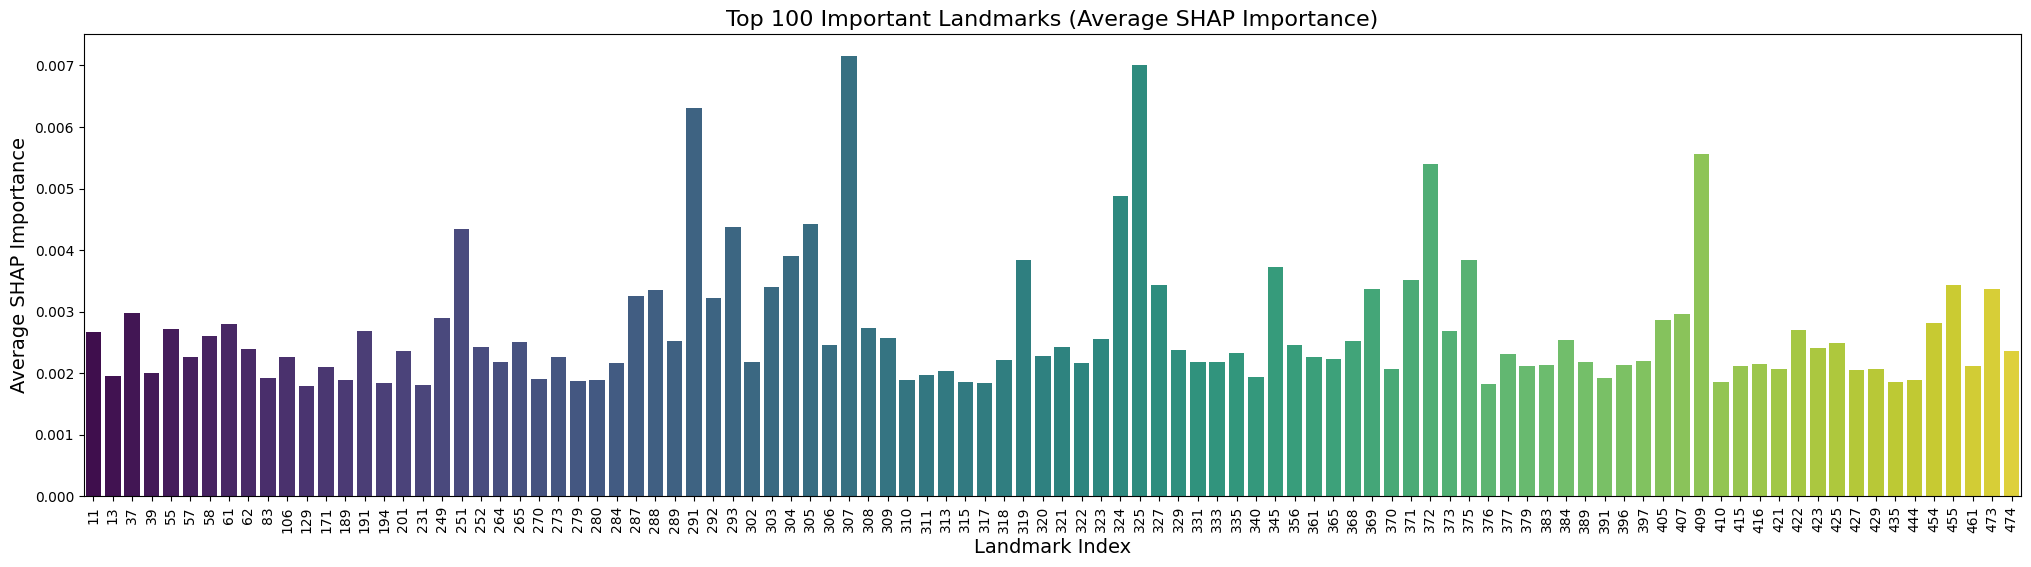

In [30]:
sorted_indices = torch.argsort(-shap_landmark_importance_avg)

sorted_importance = shap_landmark_importance_avg[sorted_indices]
sorted_landmarks = sorted_indices.tolist()

top_k = 100  # Number of top landmarks to show
df = pd.DataFrame({
    'Landmark Index': sorted_landmarks[:top_k],
    'Average SHAP Importance': sorted_importance[:top_k].numpy()
})
print(f"Top {top_k} landmarks: {sorted_landmarks[:top_k]}")
DATA_FILE = f'top_{top_k}_important_landmarks_smile.npy'
print(f"Saving to {DATA_FILE}...")
np.save(DATA_FILE, np.array(sorted_landmarks[:top_k]))

plt.figure(figsize=(25, 6))
sns.barplot(x='Landmark Index', y='Average SHAP Importance', data=df, palette='viridis')
plt.title(f'Top {top_k} Important Landmarks (Average SHAP Importance)', fontsize=16)
plt.xlabel('Landmark Index', fontsize=14)
plt.ylabel('Average SHAP Importance', fontsize=14)
plt.xticks(rotation=90)
plt.show()

### Wizualizacja przy wykorzystaniu punktów referencyjnych:

In [31]:
reference_landmarks = np.load(os.path.join('..', '..', '..', '..', 'data', 'reference_points', 'key_points_xyz.npy'))[0, :, :2]
number_landmarks = reference_landmarks.shape[0]

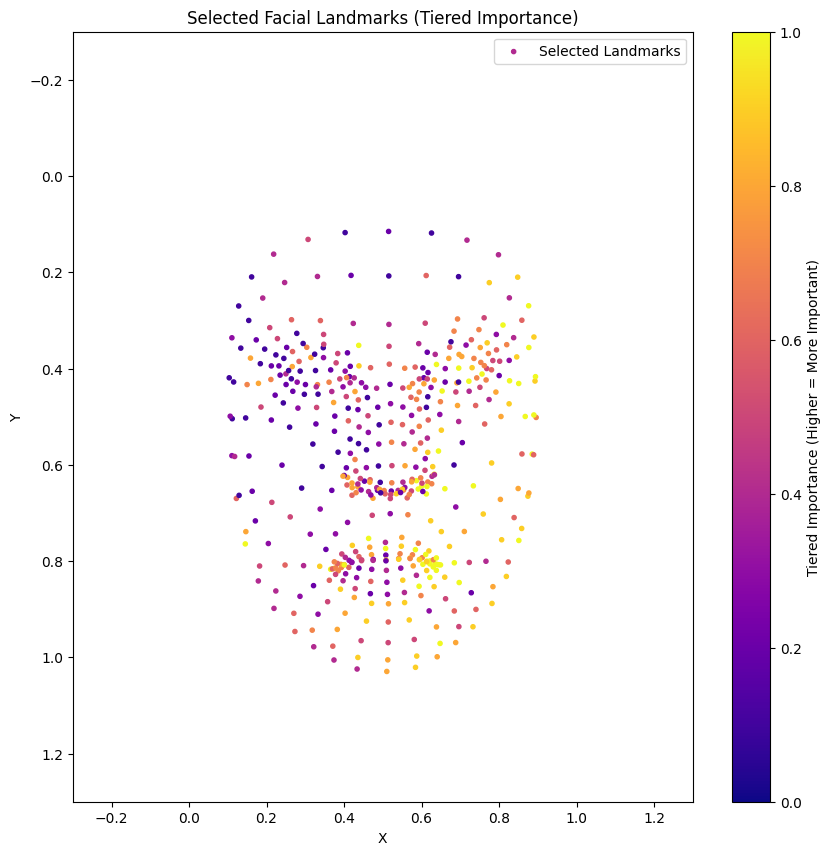

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

n_tiers = 10

# Rank-based importance: segment landmarks into `n_tiers` groups
sorted_indices = np.argsort(shap_landmark_importance_avg)
tiered_importance = np.zeros_like(shap_landmark_importance_avg)

for i in range(n_tiers):
    start = int(i * len(sorted_indices) / n_tiers)
    end = int((i + 1) * len(sorted_indices) / n_tiers)
    tiered_importance[sorted_indices[start:end]] = (i + 1) / n_tiers

# Plotting
cmap = plt.get_cmap('plasma')

plt.figure(figsize=(10, 10))
scatter = plt.scatter(
    reference_landmarks[:, 0],
    reference_landmarks[:, 1],
    c=tiered_importance,
    cmap=cmap,
    marker='.',
    label='Selected Landmarks',
    norm=Normalize(vmin=0, vmax=1)
)

plt.gca().invert_yaxis()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Selected Facial Landmarks (Tiered Importance)")
plt.legend()

AXIS_OFFSET = 0.3
plt.xlim(0 - AXIS_OFFSET, 1 + AXIS_OFFSET)
plt.ylim(1 + AXIS_OFFSET, 0 - AXIS_OFFSET)

cbar = plt.colorbar(scatter)
cbar.set_label('Tiered Importance (Higher = More Important)')

plt.show()


### Interaktywna selekcja 

In [23]:
import plotly.graph_objects as go

fig = go.Figure()

frames = []
for t in range(1, number_landmarks):
    landmarks_plot = go.Scatter(
        x=[p[0] for p in reference_landmarks[[sorted_landmarks[:t]]][0]],
        y=[1 - p[1] for p in reference_landmarks[[sorted_landmarks[:t]]][0]],
        mode='markers',
        marker=dict(
            size=10,
            color='red',
            opacity=1
        )
    )

    frames.append(go.Frame(
        data=[landmarks_plot],
        name=str(t)
    ))

fig.frames = frames

fig.add_trace(go.Scatter(
    x=[p[0] for p in reference_landmarks[:1]],
    y=[1 - p[1] for p in reference_landmarks[:1]],
    mode='markers',
    marker=dict(
        size=10,
        color='red',
        opacity=1
    )
))

AXIS_OFFSET = 0.30
fig.update_layout(
    height=800,
    width=800,
    title="Most Important Landmarks",
    xaxis=dict(range=[0 - AXIS_OFFSET, 1 + AXIS_OFFSET], title="X coord"),
    yaxis=dict(range=[0 - AXIS_OFFSET, 1 + AXIS_OFFSET], title="Y coord"),
    sliders=[{
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "no. landmarks: ",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": [{
            "args": [
                [f.name],
                {
                    "frame": {"duration": 300, "redraw": True},
                    "mode": "immediate",
                    "transition": {"duration": 300}
                }
            ],
            "label": f.name,
            "method": "animate"
        } for f in frames]
    }]
)

fig.show()